# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import lightgbm as lgb

from ydata_profiling import ProfileReport
from pandas.core.common import SettingWithCopyWarning
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
%matplotlib inline

In [3]:
try:
    initial_data = pd.read_csv('datasets/autos.csv')
except:
    raise Exception('Something is wrong. Check the file')

In [4]:
initial_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

У нас имеется датасет с 354369 объектами, где признаки:
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

Целевым признаком является **Price** — цена(в евро). Мы будем предсказывать цену автомобиля, т.е. численное значение. Обучение с учителем, и обучим несколько моделей, среди которых будут градиентный бустинг при помощи LightGBM, обычная линейная регрессия и случайный лес для регрессии. Метрикой качества для нас будет являться RMSE, которую желательно получить меньше 2500. Чем меньше, тем лучше. Однако перед обучением нам нужно произвести предобработку данных, включающую в себя:
- устранение признаков, которые не пригодятся для обучения модели
- устранение пропусков
- проверка аномалий
- проверка дубликатов

И непосредственно перед обучением:
- разделение выборок
- кодирование категориальных признаков
- скалирование значений

### Предобработка данных

Среди признаков есть такие, которые не должны оказывать влияние на стоимость автомобиля. Использовать их для обучения смысла нет. Это признаки:
- **DateCrawled** (не имеет связи с продаваемым объектом)
- **RegistrationMonth**, **RegistrationYear** (маловероятно, что порядковый номер месяца или год постановки на учет оказывают значимое влияние на стоимость. Например, год выпуска авто был бы более полезным)
- **DateCreated** (еще одна служебная информация, не связанная напрямую с объектом продажи)
- **NumberOfPictures** (изменение кол-ва фотографий авто вряд ли влияет на стоимость продажи, но может повышать заинтересованность самой анкеты)
- **PostalCode** (почтовый индекс не должен оказывать значимое влияние на стоимость)
- **LastSeen** (служебная информация анкеты)

In [6]:
# удаляем ненужные для задачи признаки
drop_features = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 
                 'PostalCode', 'LastSeen', 'RegistrationYear']
data = initial_data.drop(drop_features, axis=1)

In [7]:
# взглянем на аналитику датасета в едином окне
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Видим, что у собранных данных много проблем. Наличие дубликатов, много пропусков, есть предупреждения высокой корреляции с целевым признаком, есть аномалии со странными минимумами и максимумами и перекосы значений. Постараемся последовательно устранить всё, что получится.

#### Дубликаты

In [8]:
# проверим кол-во явных дубликатов стандартным методом pandas
data.duplicated().sum()

73748

Есть существенное различие в кол-ве дубликатов с профайлером, но нам так или иначе нужно извести повторяющиеся строки под корень.

In [9]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

Мы удалили дубликаты. Проверим также неявные дубликаты для части категориальных значений, где дубликаты возможны, а вариаций не слишком много.

In [10]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand']
for i in cat_features:
    print(f'{i}:')
    print('------------------------')
    print(data[i].value_counts())
    print('------------------------')

VehicleType:
------------------------
sedan          70413
small          57961
wagon          51092
bus            23925
convertible    17081
coupe          13910
suv            10456
other           3140
Name: VehicleType, dtype: int64
------------------------
Gearbox:
------------------------
manual    207891
auto       56656
Name: Gearbox, dtype: int64
------------------------
FuelType:
------------------------
petrol      167617
gasoline     77810
lpg           4864
cng            511
hybrid         218
other          198
electric        89
Name: FuelType, dtype: int64
------------------------
Brand:
------------------------
volkswagen        54434
opel              29956
bmw               28204
mercedes_benz     26917
audi              23335
ford              20279
renault           14261
peugeot            8996
fiat               8056
seat               5721
mazda              4861
skoda              4752
citroen            4666
smart              4569
nissan             4274
to

Неявных дубликатов нет.

#### Пропуски

Пропуски присутствуют в разных столбцах в разном количестве. А именно:

In [11]:
(data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']].isna().sum() / len(data)).round(4) * 100

VehicleType    11.63
Gearbox         5.73
Model           6.28
FuelType       10.45
Repaired       21.40
dtype: float64

Пропуски присутствуют только в категориальных признаках, поэтому мы не сможем заполнять средними или медианными значениями. У нас нет никакой информации о том, полностью случайные эти пропуски или зависят от чего-то для нас неизвестного. К сожалению, нельзя однозначно верно заполнить все пропуски с параметрами авто, угадывая тип авто по коробке передач или модель по типу топлива. Для этого может потребоваться отдельное исследование. Однако в разных столбцах уже присутствует категория *other*, поэтому к ней и отнесем пропуски. Для пропусков коробки передач возьмем моду. 

Единственное исключение — это факт ремонта. Для нашего сервиса «Не бит, не крашен» факт серьезного ремонта может быть очень важен. Скорее всего авторы анкет полностью пропускают этот пункт анкеты, если ремонта не было, поэтому заполним пропуски как если бы ремонта не было. Таких пропусков больше 20%. Так как это явно бинарный признак, то сразу привидем его к 0 и 1, где факт ремонта — 1.

In [12]:
data[['VehicleType', 'Model', 'FuelType']] = data[['VehicleType', 'Model', 'FuelType']].fillna('other')
data['Gearbox'] = data['Gearbox'].fillna('manual')
data['Repaired'] = data['Repaired'].fillna('no')
data.isna().sum().sum()

0

In [13]:
def set_cat(value):
    '''Функция бинаризует факт ремонта'''
    return 0 if value == 'no' else 1

In [14]:
data['Repaired'] = data['Repaired'].apply(set_cat)

In [15]:
data.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,other,manual,0,golf,150000,petrol,volkswagen,0
1,18300,coupe,manual,190,other,125000,gasoline,audi,1
2,9800,suv,auto,163,grand,125000,gasoline,jeep,0
3,1500,small,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,manual,69,fabia,90000,gasoline,skoda,0


#### Корреляция

Для задач регрессии высокая корреляция между признаками может оказывать значение на результативность модели. Первоначально профайлер посчитал, что между мощностью и ценой есть большая корреляция, хотя по таблице она была в районе средней. Проверим еще раз уже после произведенных ранее манипуляций.

In [16]:
data[['Price', 'Power']].corr()

,Price,Power
Price,1.000000,0.139003
Power,0.139003,1.000000


Видим, что причин для беспокойства больше нет.

#### Аномалии

Ранее мы видели аномалии почти во всех численных признаках. Взглянем еще раз после последних изменений.

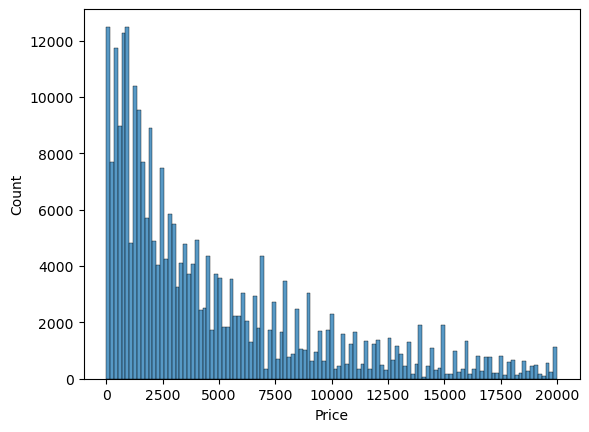

In [17]:
# посмотрим, какие есть цены
sns.histplot(data=data['Price']);

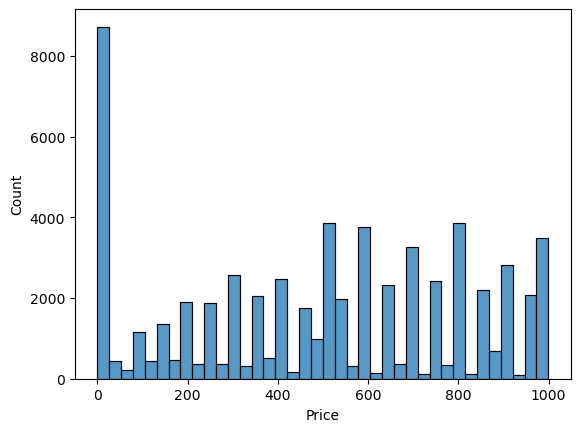

In [18]:
sns.histplot(data.query('Price < 1000')['Price']);

Легко можно допустить, что какие-то автомобили могут стоить 20000 евро (бывают и намного дороже), но стоимость в 0 евро смотрится странно. Это даже можно считать пропуском, если составитель анкеты цену не указал вовсе и подставилось автоматически 0. Можем заполнить объекты с нулевой суммой средним значением.

In [19]:
data.loc[data['Price'] == 0] = data.query('Price > 0')['Price'].mean()

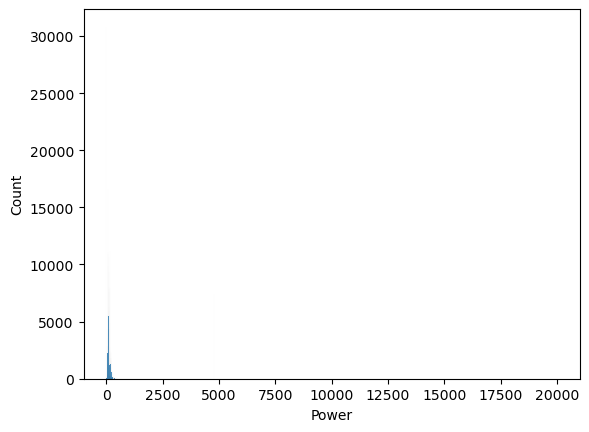

In [20]:
sns.histplot(data=data['Power']);

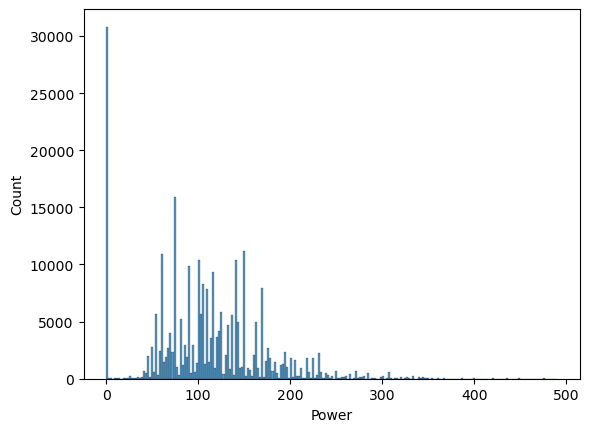

In [21]:
sns.histplot(data.query('Power < 500')['Power']);

Что касается мощности двигателя, то есть и 0, и 20000 л.с. Оба варианта являются аномальными. Двигатель без какой-либо мощности бесполезен, и только гоночные болиды и суперкары могут выйти за 1000 л.с. Возьмем порог в 500 л.с. (а диапазон среднего для 400), а также избавимся от нулей.

In [22]:
# заменяем нулевые значения средними из адекватного диапазона
data.loc[data['Power'] == 0, 'Power'] = data.query('Power < 400 and Power > 0')['Power'].mean()

In [23]:
# смотрим, сколько процентов занимают объекты с мощностью более 500 л.с.
(data.query('Power > 500')['Power'].count() / data['Power'].count()) * 100

2.805563375513593

От 2.8% можем безболезненно избавиться.

In [24]:
data = data.query('Power < 500')

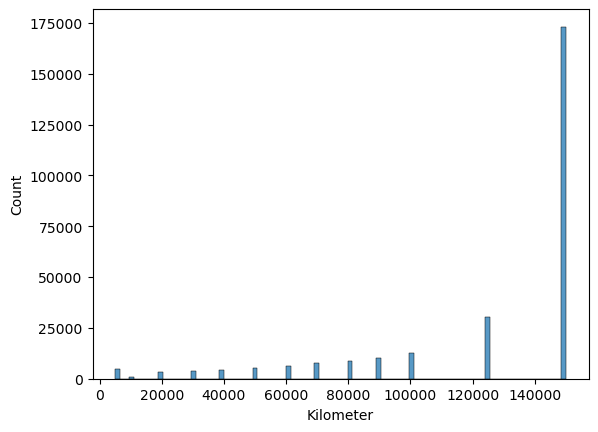

In [25]:
# на всякий случай взглянем на пробег
sns.histplot(data['Kilometer']);

Не видно ничего аномального.

#### Выборки

Для дальнейшей работы мы разделим датасет на тренировочную и тестовую выборки, чтобы не было утечки данных.

In [26]:
# обозначим единый рандом для всей дальнейшей работы
RANDOM_STATE = 999

In [27]:
# разделим признаки
features = data.drop(['Price'], axis=1)
target = data['Price']

In [28]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(204535, 8)
(68179, 8)
(204535,)
(68179,)


Непосредственно перед обучением моделей нам нужно произвести кодирование и скалирование. Для линейной регрессии нам потребуется OHE, а вот для случайного леса пригодится OrdinalEncoder, он может оказать влияние на качество.

In [29]:
# все категориальные признаки для кодирования
encode_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model']
# все количественные признаки для скалирования
scale_features = ['Power', 'Kilometer']

In [30]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

Применим последовательную трансформацию разных типов данных.

In [31]:
col_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), encode_features),
    (StandardScaler(), scale_features),
    remainder='passthrough',
    verbose_feature_names_out=False
)


features_train_ohe = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.fit_transform(features_train_ohe),
    columns=col_transformer.get_feature_names_out()
)


features_train_ohe.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,...,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,Power,Kilometer,Repaired
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.130194,0.621536,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.380704,0.621536,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006794,0.621536,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.536956,0.621536,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.640367,-2.694420,0.0


Теперь переходим к обучению моделей.

## Обучение моделей

Начнем с линейной регрессии Ridge. Сейчас нам нужно найти среди трех моделей ту, которая укладывается в рамки качества за разумное время обучения.

### Линейная регрессия

Попробуем проверить, как справится обычная линейная регрессия. Получим оценки кросс-валидацией.

In [32]:
%%time
model_ridge = Ridge(random_state=RANDOM_STATE)

# гиперпараметры
param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_ridge.fit(features_train_ohe, target_train)

# лучшее значение RMSE
print(f'Best RMSE: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Best parameters: {gs_ridge.best_params_}')

Best RMSE: 3062.3150584335913
Best parameters: {'alpha': 0.14}
Wall time: 46.4 s


Как мы видим, результаты не дотягивают до приемлемых для нас значений. Попробуем случайный лес с подбором гиперпараметров.

### Случайный лес

Случайный лес порой может лучше работать, если применять для обширных групп категорий порядковое кодирование, поэтому здесь для признака Model используем именно его. С помощью пайплайна сразу трансформируем, обучим и проведем кросс-валидацию.

In [33]:
#features_train_ord = features_train.copy()

In [34]:
# модель закомментирована, чтобы при перезапуске тетрадки не ждать её долгого обучения
# %%time
# col_transformer_rf= make_column_transformer(
#     (OneHotEncoder(drop='first', handle_unknown='ignore'), encode_features[0:4]
#     ),
#     (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['Model']
#     ),
#     (StandardScaler(), scale_features
#     ),
#     remainder='passthrough'
# )

# model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

# pipline_rf = make_pipeline(col_transformer_rf, model_rf)

# param_grid_rf = {
#     'randomforestregressor__n_estimators': range(50, 251, 50),
#     'randomforestregressor__max_depth': range(2, 15),
#     'randomforestregressor__min_samples_split': (2, 3, 4),
#     'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
# }

# # воспользуемся RandomizedSearchCV, чтобы не ждать слишком долго
# gs_rf = RandomizedSearchCV(
#     pipline_rf, 
#     param_distributions=param_grid_rf, 
#     scoring='neg_root_mean_squared_error', 
#     n_jobs=-1, 
#     random_state=RANDOM_STATE
# )

# gs_rf.fit(features_train_ord, target_train)

# print(f'best RMSE: {gs_rf.best_score_ * -1}')
# print(f'best parameters: {gs_rf.best_params_}')

best RMSE: 2457.1949284955936
best parameters: {'randomforestregressor__n_estimators': 250, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_depth': 14}
Wall time: 41min 1s

### Градиентный бустинг

In [35]:
# закодируем для бустинга только порядковым кодированием
features_train_ord = features_train.copy()
features_test_ord = features_test.copy()
col_transformer_ord = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), encode_features),
    (StandardScaler(), scale_features),
    remainder='passthrough'
)

features_train_ord = pd.DataFrame(
    col_transformer_ord.fit_transform(features_train_ord), columns=features_train_ord.columns
)


features_train_ord.head()

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.0,1.0,2.0,10.0,112.0,-0.130194,0.621536,0.0
1,7.0,1.0,6.0,39.0,21.0,1.380704,0.621536,1.0
2,6.0,1.0,2.0,18.0,89.0,-0.006794,0.621536,0.0
3,4.0,1.0,2.0,1.0,32.0,0.536956,0.621536,0.0
4,5.0,1.0,2.0,30.0,120.0,-0.640367,-2.694420,0.0


In [36]:
params = [{
    'objective': ['regression'],
    'metric': ['rmse'],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}]

# Создание модели
model = lgb.LGBMRegressor(random_state=RANDOM_STATE)

# Поиск лучших параметров с помощью GridSearchCV
grid_search = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(features_train_ord, target_train)

# Вывод лучших параметров и значения RMSE
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best RMSE: {-grid_search.best_score_}')

Best parameters: {'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 100, 'objective': 'regression'}
Best RMSE: 2362.6167562223077


В итоге мы увидели, что наилучший RMSE показал градиентный бустинг при помощи LGBMRegressor. Линейнай регрессия Ridge быстрее всех обучается, но результат обучения хуже всех. Случайный лес по качеству уступил градиентному бустингу не намного, но обучение без кросс-валидации по готовым гиперпараметрам все равно будет дольше. По итогу проверим бустинг на тестовой выборке.

## Анализ моделей

In [37]:
features_train_1, features_test_1, target_train_1, target_test_1 = train_test_split(
    features_train, target_train, test_size=0.4, random_state=RANDOM_STATE
)
print(features_train_1.shape)
print(features_test_1.shape)
print(target_train_1.shape)
print(target_test_1.shape)

(122721, 8)
(81814, 8)
(122721,)
(81814,)


In [38]:
features_train_ord_1 = features_train_1.copy()
features_test_ord_1 = features_test_1.copy()

col_transformer_ord_1 = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), encode_features),
    (StandardScaler(), scale_features),
    remainder='passthrough'
)

features_train_ord_1 = pd.DataFrame(
    col_transformer_ord_1.fit_transform(features_train_ord_1), columns=features_train_ord_1.columns
)

features_test_ord_1 = pd.DataFrame(
    col_transformer_ord_1.transform(features_test_ord_1), columns=features_test_ord_1.columns
)

features_test_ord_1.head()

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,7.0,1.0,6.0,2.0,11.0,0.125011,0.623149,0.0
1,5.0,1.0,6.0,30.0,120.0,1.146505,0.623149,0.0
2,6.0,1.0,2.0,10.0,135.0,0.341096,-1.407998,0.0
3,3.0,1.0,5.0,38.0,116.0,-0.994704,0.623149,0.0
4,5.0,1.0,6.0,1.0,28.0,0.537537,0.623149,0.0


In [39]:
final_model = lgb.LGBMRegressor(objective='regression', learning_rate=0.1, num_leaves=100, random_state=RANDOM_STATE)

In [40]:
%%time
final_model.fit(features_train_ord_1, target_train_1)

Wall time: 239 ms


LGBMRegressor(num_leaves=100, objective='regression', random_state=999)

In [41]:
%%time
preds_ord_1 = final_model.predict(features_test_ord_1)

Wall time: 46.9 ms


In [42]:
%%time
print(mean_squared_error(target_test_1, preds_ord_1, squared=False))

2353.887213662401
Wall time: 0 ns


## Тестирование лучшей модели

In [43]:
# трансформируем тестовую выборку по трансформеру трейна
features_test_ord = pd.DataFrame(
    col_transformer_ord.transform(features_test_ord), columns=features_test_ord.columns
)

features_test_ord.head()

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,3.0,1.0,5.0,25.0,8.0,-0.006794,-0.016148,0.0
1,4.0,1.0,2.0,1.0,31.0,1.105995,0.621536,0.0
2,7.0,1.0,5.0,38.0,116.0,-0.934698,0.621536,0.0
3,5.0,0.0,6.0,38.0,116.0,0.046404,0.621536,0.0
4,7.0,0.0,6.0,31.0,163.0,0.536956,-0.016148,0.0


In [44]:
%%time
final_model_test = lgb.LGBMRegressor(learning_rate=0.1, num_leaves=100, objective='regression', random_state=RANDOM_STATE)
final_model_test.fit(features_train_ord, target_train)

Wall time: 370 ms


LGBMRegressor(num_leaves=100, objective='regression', random_state=999)

In [45]:
%%time
preds = final_model_test.predict(features_test_ord)

Wall time: 31.1 ms


In [46]:
print('RMSE', mean_squared_error(target_test, preds, squared=False))

RMSE 2379.435217047303


## Вывод

В ходе данного исследования мы построили три разные модели, чтобы оценить сразу несколько важных для нас факторов:
1. Скорость обучения модели
2. Скорость получения предсказаний
3. Качество работы относительно RMSE

Сначала мы предобработали данные: убрали дубликаты и аномалии, также заполнили пропуски. После закодировали категориальные признаки и скалировали количественные. В итоге получилось так, что модель регрессии градиентного бустинга по всем параметрам показала лучший результат, а именно:

| Показание                                                              | Валидац.     |Тестовая      |
|------------------------------------------------------------------------|--------------|--------------|
| Скорость обучения модели                                               | 239 мс       | 370 мс       |
| Скорость получения предсказаний                                        | 46.9 мс      | 31.1 мс      |
| RMSE                                                                   | 2362         | 2379         |

Тестовая выборка в три раза меньше трейновой. 

Рекомендую использовать для предсказания стоимости автомобилей градиентный бустинг.